In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from math import radians, degrees, sin, cos, asin, acos, sqrt

In [4]:
# Read in data file
df = pd.read_csv('addresses.csv')

We now format the incidents as a GeoDataFrame. We want to search for all incidents within a radius specified by distance miles. To do this we have to be careful about which coordinate reference system (CRS) we use. First, we define the coordinate reference system to be EPSG:4326, which is the World Geodetic System 1984 and has units of degrees. Then we transform to a projected coordinate system with units of meters. Here we use EPSG:26986, Massachusetts Mainland. 

In [30]:
lat_lons = [Point(lon, lat) for lat, lon in zip(df['latitude'], df['longitude'])]
incidents = gp.GeoDataFrame(df, geometry=lat_lons, crs=4326).to_crs(26986) #26986 has units of meters

In [31]:
def nearby(lat, lon, radius=1):
    """ Finds all incidents within a certain radius of a specified point
    lat, lon (degrees): center of search area
    radius (miles): radius of search area
    """
    center = gp.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)

    radius_in_meters = radius * 1609.34 # convert from miles to meters
    
    search_area = gp.GeoDataFrame(geometry = center.to_crs(26986).buffer(radius_in_meters))
    
    incidents_within_range = incidents.sjoin(search_area, how = "inner")

    return incidents_within_range

For example, we can now show all of the incidents that occured within 2 miles of (lat=42.708360, lon=-73.190231).

In [40]:
lat = 42.708360
lon = -73.190231
radius = 2
plot_these_points = nearby(lat, lon, radius)
plot_these_points

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,date,change_idx,log_num,pdf_page,call_datetime,disp_datetime,enrt_datetime,...,street,narrative,loc,point,latitude,longitude,altitude,dist_to_point,geometry,index_right
0,0,0,0,2020-01-01,12,20-1,1,2020-01-01 00:36:00,NaN,NaN,...,"BERKSHIRE DRIVE, Williamstown, MA 01267",Narrative: Unable license online to renew vehi...,"Berkshire Drive, Williamstown, Berkshire Count...","(42.70836, -73.19023082142857, 0.0)",42.708360,-73.190231,0.0,0.000083,POINT (61535.420 941124.010),0
1,1,1,1,2020-01-01,99,20-2,1,2020-01-01 01:28:00,2020-01-01 01:29:45,NaN,...,"N HOOSAC ROAD, Williamstown, MA 01267",Narrative: Erratic from North Adams. opp Maroo...,"North Hoosac Road, The Spruces Park, Williamst...","(42.715679, -73.186634, 0.0)",42.715679,-73.186634,0.0,0.537656,POINT (61846.113 941931.069),0
2,2,2,2,2020-01-01,171,20-3,1,2020-01-01 02:01:00,2020-01-01 02:03:32,2020-01-01 02:03:43,...,"HALL STREET, Williamstown, MA 01267",Narrative: NAPD reports light colored SUV hit ...,"Hall Street, Williamstown, Berkshire County, M...","(42.715913, -73.190723, 0.0)",42.715913,-73.190723,0.0,0.522459,POINT (61511.737 941963.689),0
3,3,3,3,2020-01-01,251,20-4,1,2020-01-01 02:04:00,2020-01-01 02:08:30,2020-01-01 02:08:42,...,"COLE AVENUE, Williamstown, MA 01267",Narrative: Activated Burglar Alarm Narrative: ...,"Cole Avenue, Williamstown, Berkshire County, M...","(42.718729, -73.1900181, 0.0)",42.718729,-73.190018,0.0,0.716510,POINT (61575.667 942275.307),0
4,4,4,4,2020-01-01,332,20-6,2,2020-01-01 02:53:00,2020-01-01 02:55:37,NaN,...,"LUCE ROAD, Williamstown, MA 01267",Narrative: Active Structure fire. 1 party stil...,"Luce Road, The Spruces Park, Williamstown, Ber...","(42.693608, -73.182195, 0.0)",42.693608,-73.182195,0.0,1.097907,POINT (62161.315 939472.557),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19969,19969,12442,12442,2019-12-31,583626,19-160962,2371,2019-12-31 01:51:00,NaN,NaN,...,"SOUTHWORTH STREET, Williamstown, MA 01267",Narrative: Checked 0151 CHECKED/SECURED Initia...,"Southworth Street, Williamstown, Berkshire Cou...","(42.7137975, -73.1999162, 0.0)",42.713797,-73.199916,0.0,0.618805,POINT (60754.132 941743.697),0
19970,19970,12443,12443,2019-12-31,583649,19-166063,2371,NaN,NaN,NaN,...,"NORTH STREET, Williamstown, MA 01267",Narrative: checked SERVICES RENDERED Phone PAR...,"North Street, Williamstown, Berkshire County, ...","(42.7134679, -73.2093116, 0.0)",42.713468,-73.209312,0.0,1.030985,POINT (59983.891 941722.470),0
19972,19972,12445,12445,2019-12-31,583765,19-16065,2371,2019-12-31 17:29:00,NaN,NaN,...,"STETSON ROAD, Williamstown, MA 01267",Narrative: league reports doors to the green s...,"Stetson Road, Williamstown, Berkshire County, ...","(42.7199797, -73.1937074, 0.0)",42.719980,-73.193707,0.0,0.822012,POINT (61276.286 942420.211),0
19973,19973,12446,12446,2019-12-31,583823,19-16066,2372,2019-12-31 22:23:00,NaN,NaN,...,"COLD SPRING ROAD, Williamstown, MA 01267",M,"Cold Spring Road, Williamstown, Berkshire Coun...","(42.7051243, -73.2223473, 0.0)",42.705124,-73.222347,0.0,1.645869,POINT (58897.516 940817.269),0


We can also show these incidents on a map.

In [41]:
plot_these_lats = plot_these_points['latitude']
plot_these_lons = plot_these_points['longitude']

In [42]:
center = gp.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
radius_in_meters = radius * 1609.34 # convert from miles to meters
search_area = gp.GeoDataFrame(geometry = center.to_crs(26986).buffer(radius_in_meters))

In [43]:
search_area.explore()

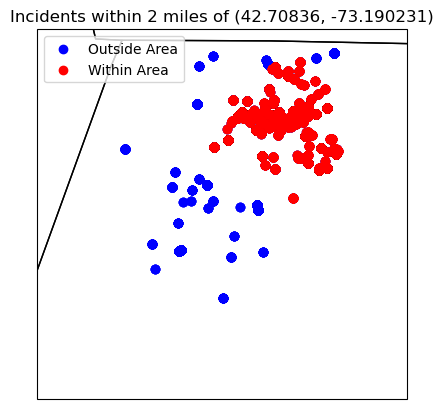

In [44]:
# Create a figure and axes
map_proj = ccrs.PlateCarree()
data_proj = ccrs.PlateCarree()
ax = plt.axes(projection=map_proj)

# Add some data points
ax.scatter(df['longitude'], df['latitude'], color='blue', transform=data_proj, label='Outside Area')
ax.scatter(plot_these_lons, plot_these_lats, color='red', transform=data_proj, label='Within Area')

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.set_extent((-73.3,-73.15,42.6,42.75),crs=map_proj)

# Add a title and labels
ax.set_title('Incidents within '+str(radius)+' miles of ('+str(lat)+', '+str(lon)+')')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.set_aspect(1)

# Show the plot
plt.show()